# Develop lstm model for time series prediction

In [59]:
# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# predictive models
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

# keras stuff
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
import tensorflow

In [19]:
class time_series_prediction():

    def __init__(self,dates,one_d_time_series,lag_window_length,n_ahead_prediction):

        # raw input data + settings for time series -> supervised learning ML problem
        self.one_d_time_series = np.array(one_d_time_series)      # time series array, to array ensure index works as expected for class methods
        self.time_series_dates = np.array(dates)                  # time stamp / date for each data point
        self.lag_window_length = lag_window_length                # length of lag window
        self.n_ahead_prediction = n_ahead_prediction              # time ahead to predict

        # transfromed data: set after calling .sliding_window_1()
        self.input_data = None
        self.target_data = None

        # testing and training data: set after calling .train_test_split()
        self.training_split = None
        self.X_test = None
        self.X_train = None
        self.y_test = None
        self.y_train = None

        # predictions from various models - set after calling each models training
        self.linear_reg_predictions = None
        self.svm_predictions = None
        self.neural_net_predictions = None
        self.naive_predictions = None

        # cumprod results from predictions - set after calling .vis_results_time_series()
        self.real_vals_cumprod = None
        self.linear_reg_predictions_cumprod = None
        self.svm_predictions_cumprod = None
        self.neural_net_predictions_cumprod = None
        self.lstm_predictions = None

# ****************************************************************************************************************
    # data wrangling
# ****************************************************************************************************************

    # method to transfroms 1-D time series to supervised ML problem: one step ahead forecasting   
    def sliding_window_1(self,verbose):
        # initialize input array
        num_rows = len(self.one_d_time_series) - self.lag_window_length
        array = np.zeros((num_rows, self.lag_window_length + 1))
        
        # loop through data and populate array
        for i in range(num_rows):
            # input features
            array[i,0:self.lag_window_length+1] = self.one_d_time_series[i:i+self.lag_window_length+1]
            # target feature/s
            array[i,-1] = self.one_d_time_series[i+self.lag_window_length]
            
            if verbose == 1:
                # show pattern
                print(array[i,0:self.lag_window_length],' : ',array[i,self.lag_window_length])

        # save results as a class attribute
        self.input_data = array[:,0:self.lag_window_length]
        self.target_data = array[:,self.lag_window_length]

    # method to perform a training and testing split for dataset with only a single column of target variables
    def train_test_split(self,split):
        self.training_split = split
        self.X_train = self.input_data[0:split,:]
        self.X_test = self.input_data[split:,:]
        self.y_train = self.target_data[0:split]
        self.y_test = self.target_data[split:]

    # method to plot testing and training split of data
    def test_train_plot(self):
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(self.time_series_dates[0:self.training_split] ,self.one_d_time_series[0:self.training_split],'k-',label='Training data') # replace returns with sp_500 for other data plotting
        ax.plot(self.time_series_dates[self.training_split:] ,self.one_d_time_series[self.training_split:],'r-',label='Testing data')
        ax.plot(self.time_series_dates[self.training_split+self.lag_window_length:] ,self.y_test,'o',label='Windowed testing data') # important to match time by start 5 (length of time window) after where segmented our testing and training data
        plt.legend(loc=0) 
        ax.set_xticks([self.time_series_dates[x] for x in range(0,len(self.time_series_dates),150)])
        ax.tick_params(rotation=30) 
        plt.tight_layout()

# ****************************************************************************************************************
    # predictive models
# ****************************************************************************************************************

    def linear_regression(self):
        print('Training multivariate linear regression:')
        # train model
        reg_model = LinearRegression().fit(self.X_train,self.y_train)
        print('\nLinear regression coefficients: \n',reg_model.coef_)

        # test model
        predictions = reg_model.predict(self.X_test)

        # evaluate: use sklearn metric methods to calc rmse and mae
        mse = mean_squared_error(self.y_test,predictions)
        mae = mean_absolute_error(self.y_test,predictions)

        print('RMSE: ',np.sqrt(mse))
        print('MAE: ',mae)

        # save predictions
        self.linear_reg_predictions = predictions

    def support_vector_machine(self):
        print('\nTraining support vector machine:')
        # train model
        svm_regres = LinearSVR(max_iter=1000,C=0.5).fit(self.X_train,self.y_train)

        # predict
        svm_predictions = svm_regres.predict(self.X_test)

        # evaluate
        mse = mean_squared_error(self.y_test,svm_predictions[:])
        mae = mean_absolute_error(self.y_test,svm_predictions[:])

        print('RMSE: ',np.sqrt(mse))
        print('MAE: ',mae)

        # save predictions
        self.svm_predictions = svm_predictions

    def neural_net_mlp(self,verbose=0):
        print('\nTraining neural network: ')
        # train neural network
        nn_regres = MLPRegressor(hidden_layer_sizes=(int(self.lag_window_length*2)),shuffle=False,random_state=1, 
                                max_iter=1000,verbose=verbose).fit(self.X_train,self.y_train)

        # make predictions
        nn_predictions = nn_regres.predict(self.X_test)

        # evaluate
        mse = mean_squared_error(self.y_test,nn_predictions[:])
        mae = mean_absolute_error(self.y_test,nn_predictions[:])

        print('RMSE: ',np.sqrt(mse))
        print('MAE: ',mae)

        # save predictions
        self.neural_net_predictions = nn_predictions

    def lstm(self):
        print('\nTraining LSTM: ')

        # transform data
        trainX = np.reshape(self.X_train, (self.X_train.shape[0], 1, self.X_train.shape[1]))
        testX = np.reshape(self.X_test, (self.X_test.shape[0], 1, self.X_train.shape[1]))
        trainY = normal.y_train
        testY = normal.y_test

        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(128, input_shape=(1, self.lag_window_length),return_sequences=True))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128, return_sequences=False))
        model.add(Dense(1),activation)
        opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=2)

        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY, testPredict))
        print('Test Score: %.2f RMSE' % (testScore))

        # save predictions
        self.lstm_predictions = testPredict

    def naive_model(self): # t's prediction is t-1's value, note that this means you miss the first time point
        preds = np.zeros(len(self.one_d_time_series)-1)
        preds[0] = np.nan()
        preds[1:] = self.one_d_time_series[0:-2]
        self.naive_predictions = preds

# ****************************************************************************************************************
    # visualize results
# ****************************************************************************************************************
    def error(self,real_data,predicted_data):
        error = np.zeros(len(real_data))
        error = (real_data - predicted_data) / real_data
        return error

    # visualize orignal time series signal aswell as predictions    
    def vis_results_time_series(self,second_plot='error'):
        # plot prediction against actual + training data
        fig, ax = plt.subplots(2,1,figsize=(10,7),sharex=True)

        # original time series
        ax[0].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.one_d_time_series[self.training_split+self.lag_window_length:],'o-',linewidth=3,label='real values',markersize=5) 

        # predicted y values
        ax[0].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.linear_reg_predictions,'o-',label='linear regression prediction',markersize=5)
        # ax[0].plot(self.time_series_dates,self.naive_predictions,'.--',label='naive prediction',markersize=5)
        ax[0].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.svm_predictions,'.--',label='svm prediction',markersize=5)
        ax[0].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.neural_net_predictions,'.--',label='nn prediction',markersize=5)
        # ax[0].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.lstm_predictions,'.--',label='lstm prediction',markersize=5)

        ax[0].legend()
        ax[0].set_title('Real values vs model predictions')

        # plot error plot
        if second_plot == 'error':
            error_linreg = self.error(self.y_test,self.linear_reg_predictions)
            # error_naive = error(np.array(test_data[:,-1]),naive_predictions)
            error_svm = self.error(self.y_test,self.svm_predictions)
            error_nn = self.error(self.y_test,self.neural_net_predictions)
            # error_lstm = self.error(self.y_test,self.lstm_predictions)

            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],error_linreg,'r-',label='linear reg error')
            # ax[1].plot(self.time_series_dates,error_naive[1:],'-',label='naive error')
            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],error_svm,'-',label='svm error')
            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],error_nn,'-',label='nn error')
            # ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],error_lstm,'-',label='lstm error')

            ax[1].set_title('Error signal for predictive models')
            ax[1].set_xlabel('Dates')
            ax[1].legend()
            # ax[1].set_ylim([-10,10])
            ax[1].set_xticks([self.time_series_dates[x] for x in range(self.training_split,len(self.time_series_dates),28)])
            ax[1].tick_params(rotation=30)
        
        elif second_plot == 'cumprod':

            # plot cummulative prod plots - this should only be done if input data is percentage retunrs
            self.real_vals_cumprod = (self.y_test+1).cumprod()
            self.linear_reg_predictions_cumprod = (self.linear_reg_predictions + 1).cumprod()
            self.svm_predictions_cumprod = (self.svm_predictions + 1).cumprod()
            self.neural_net_predictions_cumprod = (self.neural_net_predictions + 1).cumprod()

            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.real_vals_cumprod,'-',label='real vals cumprod')
            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.linear_reg_predictions_cumprod,'-',label='linear reg cumprod')
            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.svm_predictions_cumprod,'-',label='svm cumprod')
            ax[1].plot(self.time_series_dates[self.training_split+self.lag_window_length:],self.neural_net_predictions_cumprod,'-',label='nn cumprod')

            ax[1].set_xticks([self.time_series_dates[x] for x in range(self.training_split,len(self.time_series_dates),28)])
            ax[1].tick_params(rotation=30)
            ax[1].legend()

        # titles and save figures
        # title_string = 'S&P500 predictions _ y is '+str(column)+'_ window len is '+ str(window_length)
        # fig.suptitle(title_string)
        
        # fig_name = '../results/univariate_single_step_ahead/'+title_string+'.png'
        # plt.savefig(fig_name,facecolor='w')
        plt.tight_layout()

    # visualize predictions against real values using scatter plot
    def vis_results_scatter(self):

        # create dataframe to hold all results
        df_predictions = pd.DataFrame(index=self.time_series_dates[self.training_split+self.lag_window_length:],columns=['Real_values','linear_reg_predictions','svm_predictions','neural_net_predictions'])
        df_predictions['Real_values'] = self.y_test
        df_predictions['linear_reg_predictions'] = self.linear_reg_predictions
        df_predictions['svm_predictions'] = self.svm_predictions
        df_predictions['neural_net_predictions'] = self.neural_net_predictions

        # scatter plot with hues
        fig, ax = plt.subplots(3,1,figsize=(7,10))
        sns.scatterplot(y=df_predictions['Real_values'],x=df_predictions['linear_reg_predictions'],ax=ax[0])
        sns.lineplot(x=self.y_test,y=self.y_test,ax=ax[0],color='red')

        sns.scatterplot(y=df_predictions['Real_values'],x=df_predictions['svm_predictions'],ax=ax[1])
        sns.lineplot(x=self.y_test,y=self.y_test,ax=ax[1],color='red')

        sns.scatterplot(y=df_predictions['Real_values'],x=df_predictions['neural_net_predictions'],ax=ax[2])
        sns.lineplot(x=self.y_test,y=self.y_test,ax=ax[2],color='red')

        # plot formatting
        plt.tight_layout()

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.02287574 -0.0241664   0.02259219 -0.00254077  0.01651395 -0.01638934
 -0.01098526  0.04072622  0.02139823  0.93060417]
RMSE:  39.398799877715206
MAE:  25.519664826999854

Training support vector machine:
RMSE:  40.03789082539008
MAE:  25.634971814797154

Training neural network: 


/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RMSE:  40.36704465615749
MAE:  26.376659888919065


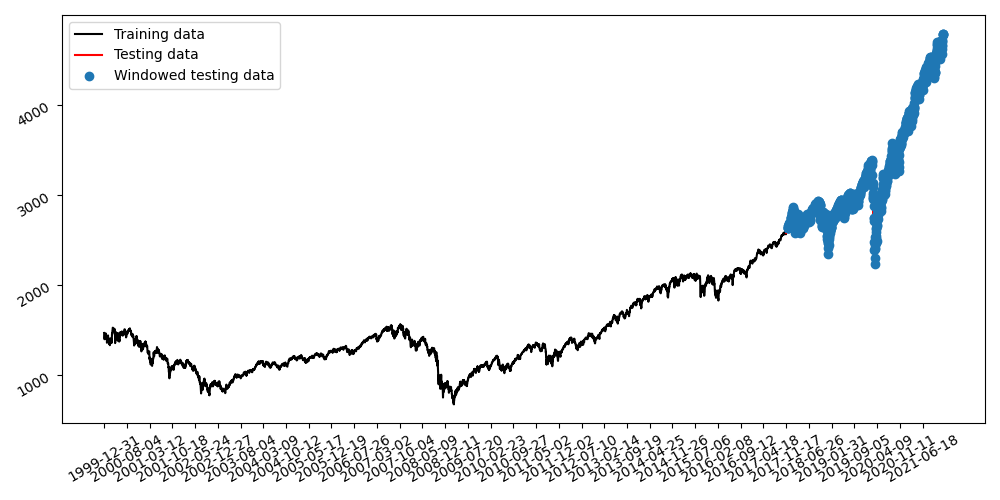

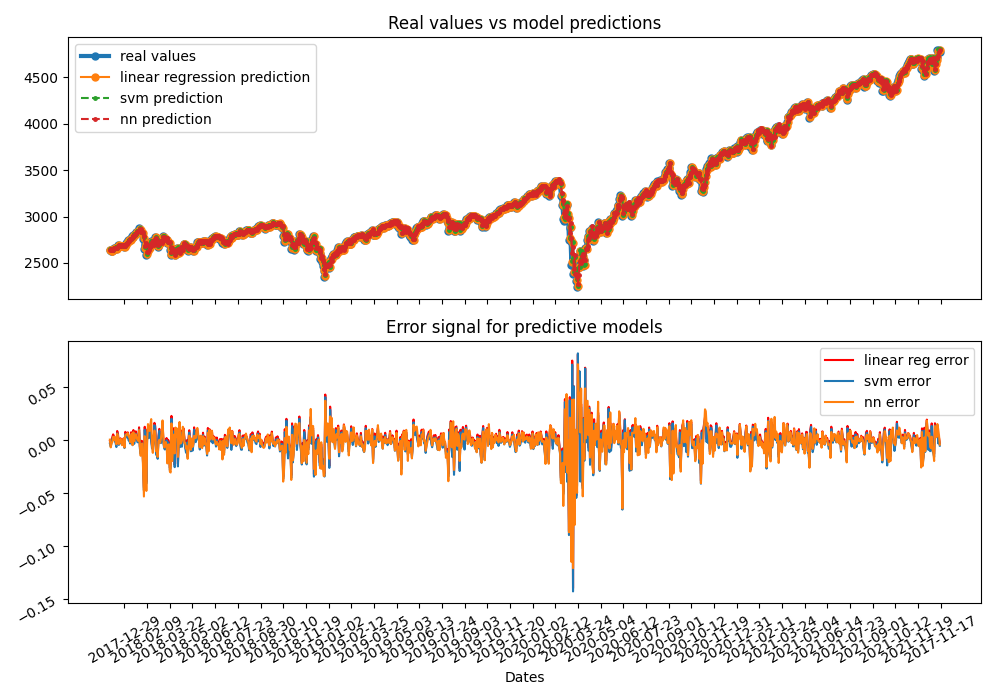

In [20]:
########################################################################
# data
########################################################################
df = pd.read_csv('./test_data/S&P500_yfinance.csv')
x = df['Close']#[-4000:]
dates = df['Date']#[-4000:]

# percentage returns
x_pct = x.pct_change().fillna(0)
x_pct

# create new df hold both
# df = pd.DataFrame(columns=['Dates','Open','pct_change','pct_change_cumprod']) # ,'log_transform'
# df['Month'] = dates
# df['Volume'] =  x
# df['pct_change'] = x_pct
# df['pct_change_cumprod'] = (x_pct + 1).cumprod()

########################################################################
# initialize class object
########################################################################
normal = time_series_prediction(df['Date'],df['Close'],10,1) # pass time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised learning ML problem
normal.train_test_split(split=4500) # testing and training dataset split
normal.test_train_plot()    # visualize training split

########################################################################
# perform some prediction tasks
########################################################################
normal.linear_regression()
normal.support_vector_machine()
normal.neural_net_mlp()

normal.vis_results_time_series(second_plot='error')

# Build LSTM

In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


In [51]:
def lstm(n_input, n_nodes, n_lstm_layers, n_epochs, n_batch, train_x, train_y,verbose=1):

    """
    This function trains a keras lstm neural network. Some important parameters are:

    :param n_input: the lag number
    :param n_nodes: number of hidden units - list with number of nodes per lstm layer
    :param n_lstm_layers: number of lstm hidden layers
    :param n_epochs: number of times training passes over the entire training set
    :param n_batch: how many training samples before weights are updated
    """

    # define model
    model = Sequential()
    
    # add initial lstm layers
    model.add(LSTM(n_nodes[0], activation= 'relu' , input_shape=(n_input, 1),return_sequences=True)) # lstm layer

    # add subsequent hidden LSTM layers
    if n_lstm_layers > 1:
        # setup hidden layers between first and last LSTM layers
        for i in range(1,n_lstm_layers-1):
            model.add(LSTM(n_nodes[i], activation= 'relu', return_sequences=True))

        # add final lstm hidden layers
        model.add(LSTM(n_nodes[i+1], activation= 'relu', return_sequences=False))

    # add a final fully connected layer + single predictor layer 
    model.add(Dense(1))                                                    # final predictor

    # prepare optimizer and compile model
    opt = Adam(learning_rate=0.001)
    model.compile(loss= 'mse', optimizer= opt)

    # setup some callbacks
    callbacks_list = [EarlyStopping(verbose=1,monitor='loss',mode='min',patience=20)]

    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=verbose, callbacks=callbacks_list)

    # show model summary
    model.summary()

    return model

In [73]:
# get data from time series prediction object

x_train = normal.X_train
y_train = normal.y_train

x_test = normal.X_test
y_test = normal.y_test


# fit model
model = lstm(
            n_input=10, 
            n_nodes=[112,112,16,112], 
            n_lstm_layers=4, # this is the number of layers specififed in n_nodes ie len(n_nodes)
            n_epochs=1000, 
            n_batch=128,
            train_x=x_train, 
            train_y=y_train,
            verbose=1)

# predict test set
yhat = model.predict(x_test, verbose=0)

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))
mae = mean_absolute_error(y_test, yhat)
print('MAE: ',mae)


Epoch 1/1000
36/36 [==============================] - 2s 18ms/step - loss: 1074514.2500
Epoch 2/1000
36/36 [==============================] - 1s 19ms/step - loss: 10555.7393
Epoch 3/1000
36/36 [==============================] - 1s 21ms/step - loss: 1690.8314
Epoch 4/1000
36/36 [==============================] - 1s 19ms/step - loss: 1255.3547
Epoch 5/1000
36/36 [==============================] - 1s 19ms/step - loss: 1174.1997
Epoch 6/1000
36/36 [==============================] - 1s 19ms/step - loss: 1284.1992
Epoch 7/1000
36/36 [==============================] - 1s 19ms/step - loss: 1103.5601
Epoch 8/1000
36/36 [==============================] - 1s 21ms/step - loss: 1086.5320
Epoch 9/1000
36/36 [==============================] - 1s 20ms/step - loss: 1091.5823
Epoch 10/1000
36/36 [==============================] - 1s 20ms/step - loss: 1056.5880
Epoch 11/1000
36/36 [==============================] - 1s 20ms/step - loss: 1020.6360
Epoch 12/1000
36/36 [==============================] - 1s 2

In [53]:
# predict test set
yhat = model.predict(x_test, verbose=0)

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))
mae = mean_absolute_error(y_test, yhat)
print('MAE: ',mae)

Test Score: 58.43 RMSE
MAE:  36.03430437530458


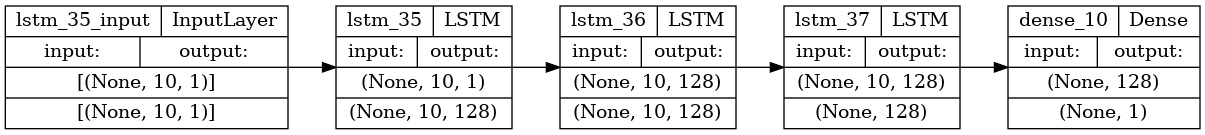

In [57]:
tensorflow.keras.utils.plot_model(
    model,
    to_file='./model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [75]:
""" 
Build LSTM hyperparemeter tuner 

Following this guide: https://keras.io/guides/keras_tuner/getting_started/
"""
def build_model(hp):

    # define model
    model = Sequential()
    
    # add initial lstm layers
    model.add(LSTM(units=hp.Int("units 0", min_value=16, max_value=288, step=32), activation= 'relu' , input_shape=(10, 1),return_sequences=True)) # lstm layer

    # setup hidden layers between first and last LSTM layers
    for i in range(hp.Int('layers',1,3)):
        model.add(LSTM(hp.Int(f"units {i}", min_value=16, max_value=288, step=32), activation= 'relu', return_sequences=True))

    # add final lstm hidden layers
    model.add(LSTM(hp.Int("units -1", min_value=16, max_value=288, step=32), activation= 'relu', return_sequences=False))

    # add a final fully connected layer + single predictor layer 
    model.add(Dense(1))                                                    # final predictor

    # prepare optimizer and compile model
    opt = Adam(learning_rate=hp.Choice('learning_rate',[1e-2,1e-3,1e-4]))
    model.compile(loss= 'mse', optimizer= opt)

    return model

# setup hyperparameter tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=5,
    overwrite=True,
    directory="./lstm_hp_res/",
    project_name="helloworld",
)

# setup data with validation set for hp tuning
X_train = x_train
Y_train = y_train

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1, shuffle=False)

# start tuning hyperparameters
tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))


Trial 20 Complete [00h 00m 58s]
val_loss: 574.9736572265625

Best val_loss So Far: 499.12156372070314
Total elapsed time: 00h 26m 24s
INFO:tensorflow:Oracle triggered exit


In [76]:
tuner.results_summary()


Results summary
Results in ./lstm_hp_res/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
units 0: 176
layers: 3
units -1: 176
learning_rate: 0.0001
units 1: 112
units 2: 48
Score: 499.12156372070314
Trial summary
Hyperparameters:
units 0: 112
layers: 2
units -1: 208
learning_rate: 0.0001
units 1: 208
Score: 557.5968933105469
Trial summary
Hyperparameters:
units 0: 48
layers: 2
units -1: 176
learning_rate: 0.0001
units 1: 176
units 2: 208
Score: 560.0595764160156
Trial summary
Hyperparameters:
units 0: 176
layers: 1
units -1: 176
learning_rate: 0.0001
units 1: 144
units 2: 144
Score: 574.9736572265625
Trial summary
Hyperparameters:
units 0: 80
layers: 1
units -1: 112
learning_rate: 0.001
units 1: 176
units 2: 16
Score: 651.6326721191406
Trial summary
Hyperparameters:
units 0: 272
layers: 2
units -1: 112
learning_rate: 0.001
units 1: 272
units 2: 240
Score: 686.4740600585938
Trial summary
Hyperparameters:
units 0: 208
layers: 2
units -1: 208
learning_rate: 0.0001
units 1

In [71]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10, 1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 112)           51072     
                                                                 
 lstm_1 (LSTM)               (None, 10, 112)           100800    
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            8256      
                                                                 
 lstm_3 (LSTM)               (None, 112)               57792     
                                                                 
 dense (Dense)               (None, 1)                 113       
                                                                 
Total params: 218,033
Trainable params: 218,033
Non-trainable params: 0
_________________________________________________________________
